<a href="https://colab.research.google.com/github/SonOf1998/COVID-19_detection_in_lungs/blob/main/COVIDDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Dec  9 12:46:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Installing packages


We'll use a model (SE-ResNet152) which is not a part of the Keras Application module so a package needs to be installed beforehand.

The short documentation and available models:  
https://github.com/qubvel/classification_models

For the optimizer we will use AdaBound, which mixes the advantages of Adam and SGD and produces good results for our model.

AdaBound implementation for Keras:
https://github.com/Luolc/AdaBound

AdaBound paper:
https://openreview.net/forum?id=Bkg3g2R9FX

In [2]:
!pip install git+https://github.com/qubvel/classification_models.git
!pip install keras-adabound
!pip install tensorboardX

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-eorzu_dg
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-eorzu_dg
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 51kB 4.7MB/s 
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-cp36-none-any.whl size=20032 sha256=624bdef6f42c4eb16ebdaa37dc9f28a5a21c7b7334860f4ace2cd54ce5e5635c
  Stored in directory: /tmp/pip-ephem-wheel-cache-c0apaue8/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers
  Created wheel for keras-adabound: filename=keras_adabound-0.6.0-cp36-none-any.whl size=6608 sha256=9fb5027a67a70c812805099e3e66568f44e68fb83b4becc28a0a92c988060a3d
  Stored in directory: /root/.cache/pip/wheels/f1/81/9c/04af926d62bddd280c97af1704a9baaef511664b56865958e8
Successfully built keras-adabound
     |████████████████████████████████

# Download datasets from Github repository
Our repository: https://github.com/SonOf1998/COVID-19_detection_in_lungs

We download the content of our repository which contains the datasets we collected and cleaned beforehand.

In [3]:
import os
from urllib.request import urlretrieve
import requests
import zipfile
import shutil
import random

In [4]:
working_dir = os.getcwd()
local_zip = os.path.join(working_dir, 'main.zip')

In [5]:
url = 'https://github.com/SonOf1998/COVID-19_detection_in_lungs/archive/main.zip'
urlretrieve(url,local_zip) # Load content of repository into a local zip file

# Extract zip file
zip_ref = zipfile.ZipFile(local_zip,'r') 
zip_ref.extractall()
zip_ref.close()

# Discard zip file
if os.path.exists(local_zip):
  os.remove(local_zip)

In [6]:
repo_root_dir = os.path.join(working_dir, 'COVID-19_detection_in_lungs-main')   # Path to the downloaded directory

# Remove unnecessary files
if os.path.exists(os.path.join(repo_root_dir, 'COVIDDetector.ipynb')):
  os.remove(os.path.join(repo_root_dir, 'COVIDDetector.ipynb'))
if os.path.exists(os.path.join(repo_root_dir, 'LICENSE')):
  os.remove(os.path.join(repo_root_dir, 'LICENSE'))
if os.path.exists(os.path.join(repo_root_dir, 'README.md')):
  os.remove(os.path.join(repo_root_dir, 'README.md'))

In [7]:
# Move dataset directory to working directory
source = os.path.join(repo_root_dir, 'image_datasets')
shutil.move(source, working_dir)

# Remove repository root directory
os.rmdir(repo_root_dir)

We print out the number of train and test images to check how much data we have.

In [8]:
# Path to the moved dataset directory
datasets_dir = os.path.join(working_dir, 'image_datasets')

train_images_dir = os.path.join(datasets_dir, 'train_image_dataset')
test_images_dir = os.path.join(datasets_dir, 'test_image_dataset')

train_covid_images_dir = os.path.join(train_images_dir, 'covid_19')
train_no_findings_images_dir = os.path.join(train_images_dir, 'no_findings')
train_pneumonia_images_dir = os.path.join(train_images_dir, 'pneumonia')

test_covid_images_dir = os.path.join(test_images_dir, 'covid_19')
test_no_findings_images_dir = os.path.join(test_images_dir, 'no_findings')
test_pneumonia_images_dir = os.path.join(test_images_dir, 'pneumonia')

print('train images: {}'.format(len(os.listdir(train_covid_images_dir))+len(os.listdir(train_no_findings_images_dir))+len(os.listdir(train_pneumonia_images_dir))))
print('train covid images: {}'.format(len(os.listdir(train_covid_images_dir))))
print('train no findings images: {}'.format(len(os.listdir(train_no_findings_images_dir))))
print('train pneumonia images: {}'.format(len(os.listdir(train_pneumonia_images_dir))))

print('test images: {}'.format(len(os.listdir(test_covid_images_dir))+len(os.listdir(test_no_findings_images_dir))+len(os.listdir(test_pneumonia_images_dir))))
print('test covid images: {}'.format(len(os.listdir(test_covid_images_dir))))
print('test no findings images: {}'.format(len(os.listdir(test_no_findings_images_dir))))
print('test pneumonia images: {}'.format(len(os.listdir(test_pneumonia_images_dir))))

train images: 1269
train covid images: 370
train no findings images: 449
train pneumonia images: 450
test images: 137
test covid images: 37
test no findings images: 50
test pneumonia images: 50


# Preparing datasets
We are going to use ImageDataGenerators to load images directly from the train and test directories while doing augmentation on the training set simultaneously.

In [9]:
img_height = 256    # Input image height
img_width = 256     # Input image width
batch_size = 32
class_mode = 'categorical'  # 3 categories: covid_19, pneumonia, no_findings
color_mode = 'rgb'  # SE-ResNet needs all 3 channels

## Data augmentation and splitting data into train, validation and test batches
In order to create more training data we allow the corresponding ImageDataGenerator to generate new instances by slightly rotating and zooming the original images. We also enable flipping and large scaled adjustments on brightness because it's reasonable to do so while working with data like that.

Also, we set the preprocessing function to the recommended one for SE-ResNet152 models.

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from classification_models.keras import Classifiers

SEResNet152, preprocess_input = Classifiers.get('seresnet152')

# 20% validation split of train datasets
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                  validation_split=0.08, rotation_range=3, 
                                  zoom_range=[1, 1.1], brightness_range=[0.85, 1.2], 
                                  horizontal_flip=True)

# generate training batches from train directory 
train_iter = train_datagen.flow_from_directory(
    train_images_dir,
    target_size=(img_height, img_width),
    batch_size = batch_size,
    class_mode = class_mode,
    color_mode = color_mode,
    seed = 42,
    shuffle = True,
    subset='training'
)

# generate validation batches from train directory
validation_iter = train_datagen.flow_from_directory(
    train_images_dir,
    target_size=(img_height, img_width),
    batch_size = batch_size,
    class_mode = class_mode,
    color_mode = color_mode,
    shuffle = False,
    subset='validation'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# generate test batches from test directory
test_iter = test_datagen.flow_from_directory(
    test_images_dir,
    target_size=(img_height, img_width),
    batch_size = 1,
    class_mode = class_mode,
    color_mode = color_mode,
    shuffle = False
)

Found 1169 images belonging to 3 classes.
Found 100 images belonging to 3 classes.
Found 137 images belonging to 3 classes.


# Data visualization
We visualize an augmented and preprocessed batch of data.

In [11]:
import numpy as np

iter = train_iter.next()    # Get the first batch of preprocessed images
xrays = iter[0]
labels = iter[1]  # One-hot encoding: 
                  # [1, 0, 0] - covid_19, 
                  # [0, 1, 0] - no_findings, 
                  # [0, 0, 1] - pneumonia

In [12]:
train_iter.class_indices

{'covid_19': 0, 'no_findings': 1, 'pneumonia': 2}

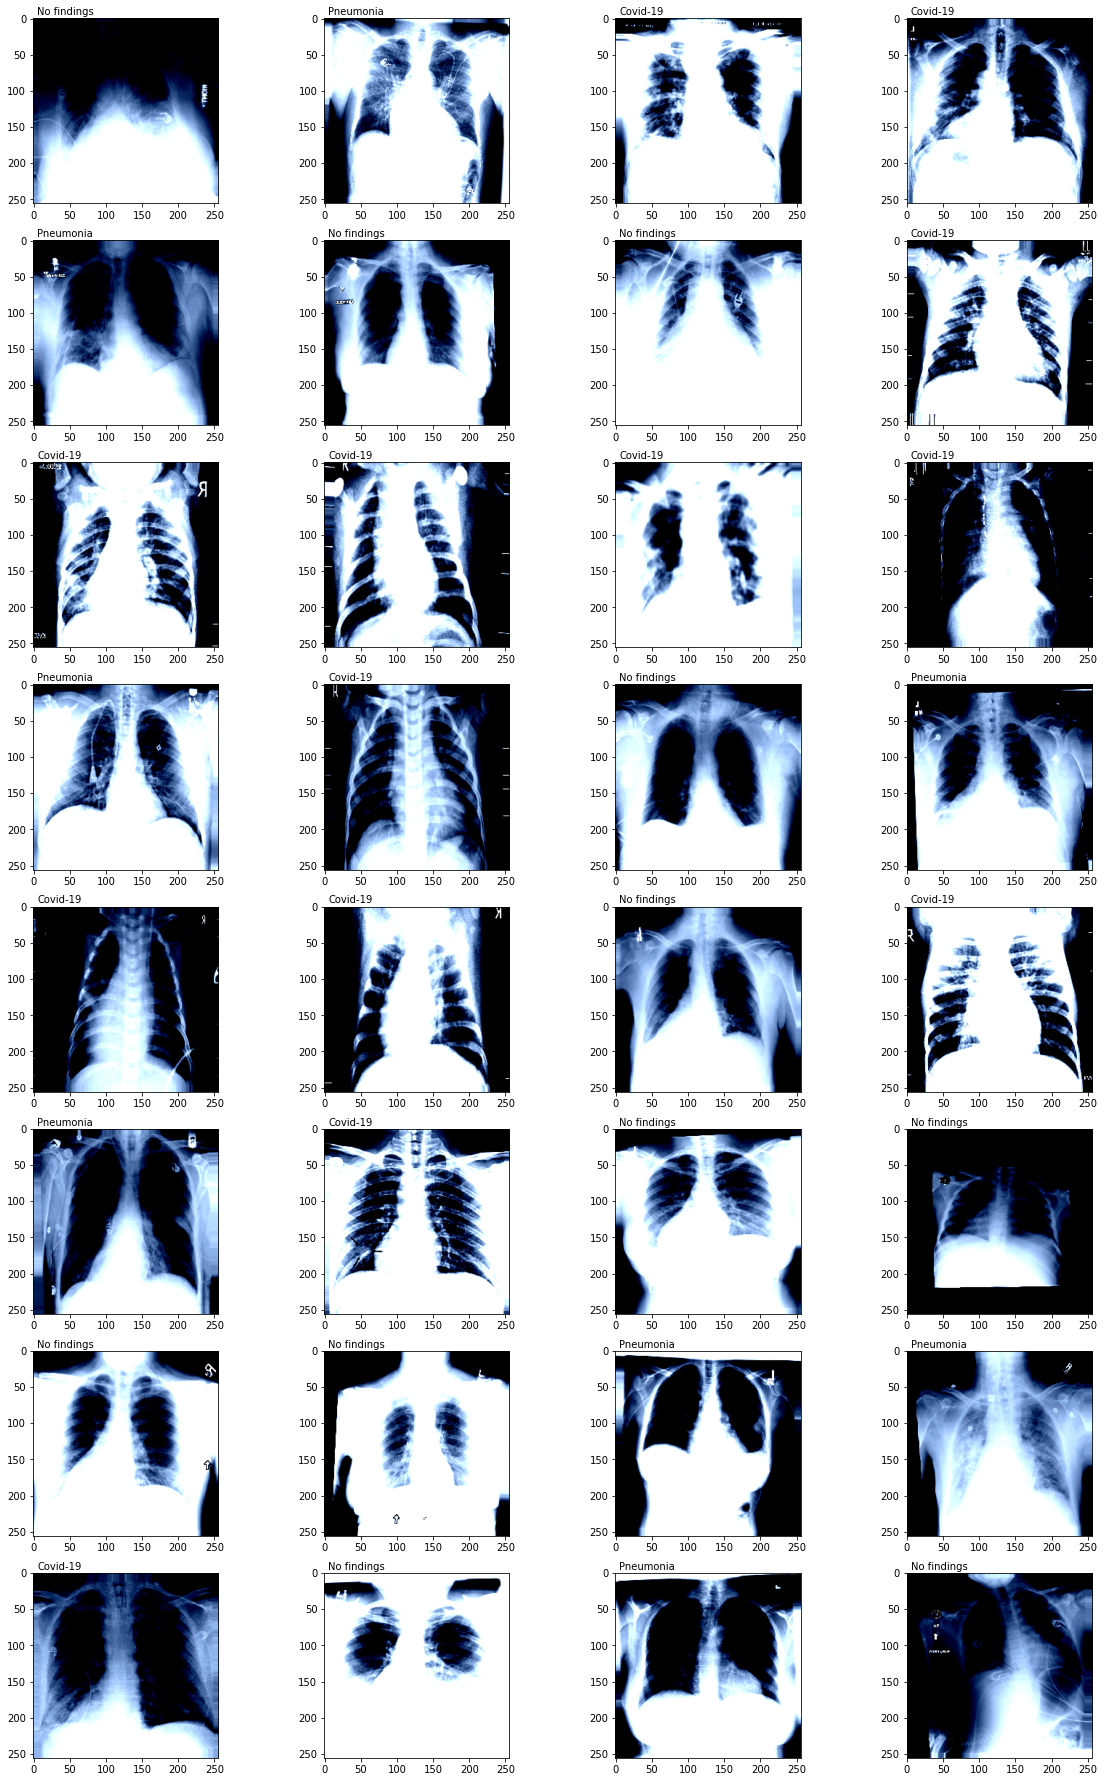

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

ncols = 4 # Preferred amount of columns
nrows = int(np.ceil(xrays.shape[0]/ncols)) # Calculate num of rows based on batch size

fig = plt.gcf()
fig.set_size_inches(ncols * 5, nrows * 4)

# Plot
for i, img in enumerate(xrays):
  sp = plt.subplot(nrows, ncols, i + 1)
  plt.imshow(np.clip(img, 0, 1))
  if(labels[i][0] == 1):
    plt.text(x = 5, y = -5, s='Covid-19')
  elif(labels[i][1] == 1):
    plt.text(x = 5, y = -5, s='No findings')
  elif(labels[i][2] == 1):
    plt.text(x = 5, y = -5, s='Pneumonia')
plt.show()

In [14]:
# Reset the iterator
train_iter.reset()
train_iter.total_batches_seen = 0

# Creating the model

We initialize our network by attaching a custom neural network to the lower parts of the SE-ResNet152 model.

We use softmax activation as we'd like to classify between 3 classes.

In [26]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, LeakyReLU
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.models import Sequential
from keras_adabound import AdaBound

In [27]:
base_model = SEResNet152(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256, 256, 3),
    classes=3
)

activation = LeakyReLU()

dense_model = Sequential([
    GlobalAveragePooling2D(),
    Dense(2560, activation=activation),
    Dropout(0.3),
    Dense(1536, activation=activation),
    Dropout(0.1),
    Dense(1024, activation=activation),
    Dropout(0.1),
    Dense(2048, activation=activation),
    Dense(3072, activation=activation),
    Dropout(0.1),
    Dense(3, activation='softmax')
])
model = Model(inputs=[base_model.input], outputs=[dense_model(base_model.output)])

# Training

Defining an EarlyStopping and ModelCheckpoint can avoid overfitting and restoring the best model we got so far.

Using the TensorBoard callback for train logging and visualization.

In [20]:
from datetime import datetime

In [21]:
# logging directory with the current time in it's name for easier identification
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

# creating the logging directory if it does not already exist
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# this is for deleting the logging directory and it's contents
# ------ ONLY USED IN DEVELOPMENT ------
#!rm -rf ./logs/

In [28]:
checkpoint = ModelCheckpoint("best_model.cp", save_best_only=True, monitor="val_accuracy", verbose=1)
early_stop = EarlyStopping(monitor="val_accuracy", patience=8)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1,  write_graph=True)

In [ ]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)


Experimentation shows that teaching the whole model from the start provides the best results.

Due to the lack of resources we only enable the training of 698 layers out of 914 in the SE-ResNet152 model.

In [30]:
split = 216
for layer in base_model.layers[:split]:
    layer.trainable = False
for layer in base_model.layers[split:]:
    layer.trainable = True

In [ ]:
optimizer = AdaBound()

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

model.fit(
    train_iter,
    epochs=10000,
    validation_data=validation_iter,
    callbacks=[tensorboard_callback, checkpoint, early_stop]
)

Epoch 1/10000
 1/37 [..............................] - ETA: 0s - loss: 1.1049 - accuracy: 0.3750WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
37/37 [==============================] - ETA: 0s - loss: 1.2990 - accuracy: 0.4919
Epoch 00001: val_accuracy improved from -inf to 0.35000, saving model to best_model.cp
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: best_model.cp/assets
37/37 [==============================] - 227s 6s/step - loss: 1.2990 - accuracy: 0.4919 - val_loss: 295815741440.0000 - val_accuracy: 0.3500
Epoch 2/10000
37/37 [====

# Evaluation
We make a quick evaluation by measuring the accuracy of the model on the test set and displaying the confusion matrix.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
import seaborn as sn
import matplotlib.pyplot as plt

In [ ]:
# restore the model with the highest validation accuracy
model = load_model("best_model.cp", custom_objects={'AdaBound': optimizer})

In [ ]:
loss, acc = model.evaluate(test_iter)
acc

In [ ]:
Y_pred = model.predict(test_iter)
y_pred = np.argmax(Y_pred, axis=1)
print('--- Classification Report ---\n')
target_names = ['covid_19', 'no_findings', 'pneumonia']
print(classification_report(test_iter.classes, y_pred, target_names=target_names))
print('--- Confusion Matrix ---\n')
hm = sn.heatmap(confusion_matrix(test_iter.classes, y_pred), annot=True, xticklabels=target_names, yticklabels=target_names)
plt.show(hm)

## TensorBoard visualization

We visualize the training metrics, the network, and make a projection of the base model's last layer.

In [ ]:
from tensorboardX import SummaryWriter

In [ ]:
# creating the submodel
model_input = model.input              
                          
model_outputs = [layer.output for layer in model.layers]

submodel = Model(model_input, model_outputs[-2])

In [ ]:
# data loader and iterator for the label images
# these are only for visualization purposes
# no predictions are made from these
img_label_datagen = ImageDataGenerator()

img_label_iter = test_datagen.flow_from_directory(
    test_images_dir,
    target_size=(682, 682),
    batch_size = 137,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    shuffle = False
)

In [ ]:
# helper function for index to class name conversion on the labels
def index_to_class_name(idx):
  if idx == 0:
    return 'covid_19'
  elif idx == 1:
    return 'no_findings'
  elif idx == 2:
    return 'pneumonia'
  else:
    return 'hiba'

In [ ]:
# loading in the test data
test_iter.reset()
test_iter.batch_size = 137

x, y = test_iter.next()

test_iter.batch_size = 1
test_iter.reset()

# labels and converting them to class names
labels = np.argmax(y,1)
labels = np.asarray([index_to_class_name(x) for x in labels])

# label images and converting the range to float for visualization
label_images, _ = img_label_iter.next()
label_images = label_images / 255.0

# submodel predictions 
predictions = submodel.predict(x)

In [ ]:
# creating the embedding for the projection
with SummaryWriter(log_dir+'/projector/predictions') as w:
  w.add_embedding(predictions.reshape(137,-1), metadata=labels, label_img=label_images.reshape(137,1,682,682), global_step=0)

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# keras example
%tensorboard --logdir logs/fit